# Inverted Pendulum LQR Control and State Estimation

This section demonstrates the modeling, simulation, and control of an inverted pendulum on a cart using Linear Quadratic Regulator (LQR) techniques. We define the system parameters, construct the state-space model, design an optimal LQR controller, and simulate the closed-loop response. Additionally, we implement a state observer to estimate the system states in the presence of measurement noise, providing insight into both control performance and observer accuracy.

## LQR Control

The python code below sets the stage for the inverted pendulum LQR control and estimation example. It provides a high-level overview of the workflow, describing the modeling, simulation, and control of an inverted pendulum on a cart using LQR techniques. The markdown explains that the notebook will:

- Define system parameters and construct a state-space model.
- Design an optimal LQR controller and simulate the closed-loop response.
- Implement a state observer to estimate system states in the presence of measurement noise.
- Analyze both control performance and observer accuracy.

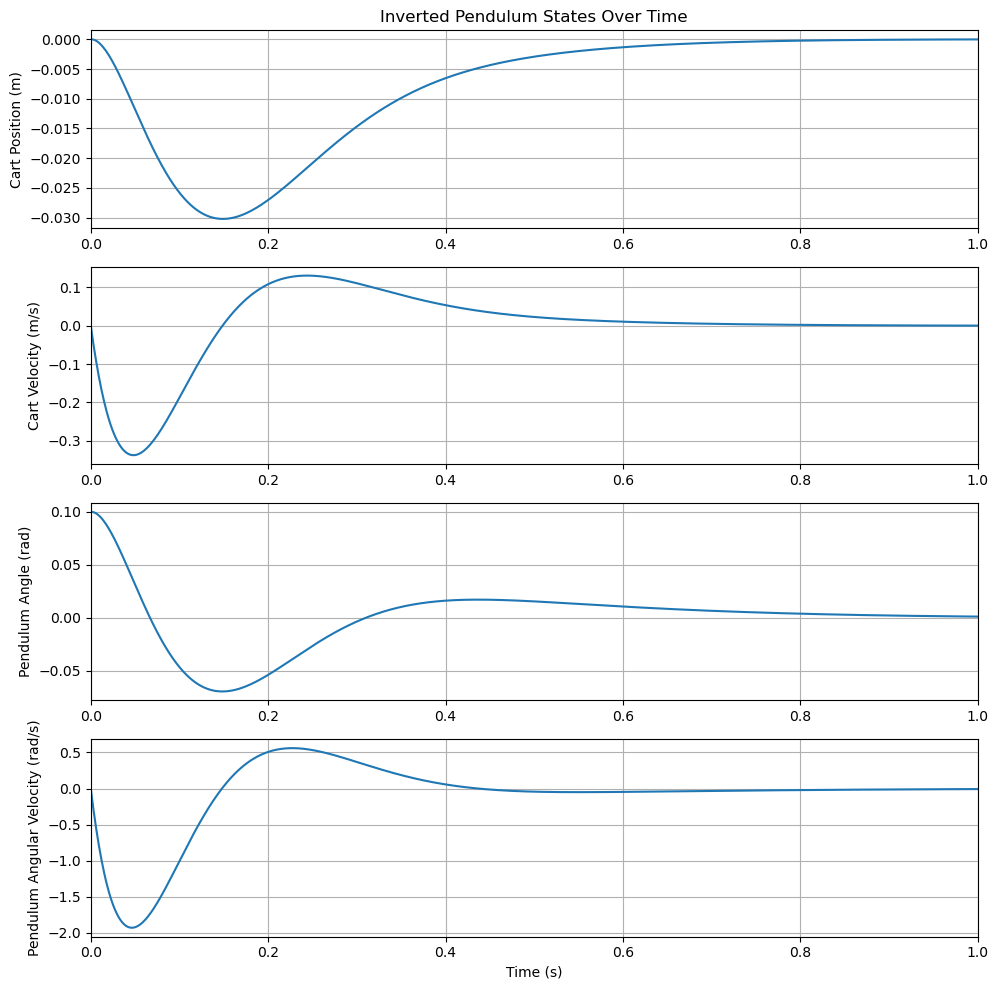

In [40]:
import numpy as np
from control import lqr, ss, forced_response

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define system parameters
m = 0.0318  # Mass of the pendulum (kg)
M = 0.3333  # Mass of the cart (kg)
l = 0.316/2  # Length of the pendulum (m)
g = 9.81  # Gravitational acceleration (m/s^2)
I = 0.0085*(0.0098**2+0.0379**2)/12 + m*((l*2)**22)/3  # Moment of inertia (kg*m^2)

# Damping coefficient (not used in LQR but can be included for more realistic dynamics)
a1 = 0.0185
c1 = 2*a1*I      # Viscous friction of pendulum 1 (rotational) (Nms/rad)

alpha = 12.2;      # Carriage slope (deg)
xdotss = 0.4852;   # Terminal velocity (m/s)
c = (M+m)*g*np.sin(alpha*np.pi/180)/xdotss;   # Damping / Viscous Friction (kg/s)

# State-space matrices
denom = (M+m)*(m*l**2+I)

A = np.array([
    [0, 1, 0, 0],
    [0, -(m*l**2+I)*c/denom, m**2*l**2*g/denom, m*l*c1/denom],
    [0, 0, 0, 1],
    [0, -m*l*c/denom, (M+m)*m*l*g/denom, (M+m)*c1/denom]
])
B = np.array([[0], [(m*l**2+I)/denom], [0], [m*l/denom]])
C = np.eye(4)
D = np.zeros((4, 1))

# Create state-space system
system = ss(A, B, C, D)

# LQR controller design
Q = np.diag([10000, 0, 100, 0])  # State cost matrix
R = np.array([[1]])        # Control effort cost
K, _, _ = lqr(A, B, Q, R)

# Simulation parameters
T = np.linspace(0, 1, 1000)  # 10 seconds, 1000 points
X0 = [0.0, 0.0, 0.1, 0.0]     # Initial state: small angle offset

# Reference (desired state)
ref = np.zeros((4, len(T)))   # Track zero for all states

# Simulate closed-loop system
def lqr_control(t, x):
    # u = -Kx
    u = -K @ x.reshape(-1, 1)
    return u.item()

X = np.zeros((4, len(T)))
X[:, 0] = X0
U = np.zeros(len(T))

dt = T[1] - T[0]
for i in range(1, len(T)):
    u = lqr_control(T[i-1], X[:, i-1])
    U[i-1] = u
    # x_dot = Ax + Bu
    x_dot = A @ X[:, i-1] + B.flatten() * u
    X[:, i] = X[:, i-1] + x_dot * dt

# Plot each state in a separate subplot
plt.figure(figsize=(10, 10))
labels = ['Cart Position (m)', 'Cart Velocity (m/s)', 'Pendulum Angle (rad)', 'Pendulum Angular Velocity (rad/s)']
for idx in range(4):
    plt.subplot(4, 1, idx + 1)
    plt.plot(T, X[idx, :])
    plt.ylabel(labels[idx])
    plt.xlim(0, 1)
    if idx == 0:
        plt.title('Inverted Pendulum States Over Time')
    if idx == 3:
        plt.xlabel('Time (s)')
    plt.grid(True)
plt.tight_layout()
plt.show()

## Optimizing Q Matrix

The graphs above display the time evolution of the cart and pendulum states under LQR control. By observing these plots, we adjusted the diagonal elements of the Q matrix to penalize deviations in specific states (e.g., cart position and pendulum angle). Increasing the weights in Q for critical states led to faster correction and smaller steady-state errors, as seen by reduced overshoot and quicker settling in the plots. This iterative process of tuning Q and reviewing the resulting state trajectories allowed us to balance performance (speed and accuracy) and control effort, achieving the desired closed-loop behavior.

## Full State Observer Design

The code below designs and simulates a state observer (Luenberger observer) for the inverted pendulum system. It estimates all four system states using noisy measurements of cart position and pendulum angle. The observer gain matrix `L` is computed by placing the observer poles for desired estimation dynamics. During simulation, measurement noise is added to the observed outputs, and the observer state is updated at each time step using the observer dynamics. The results are visualized by plotting the true states, estimated states, and noisy measurements, allowing analysis of observer performance and noise sensitivity.

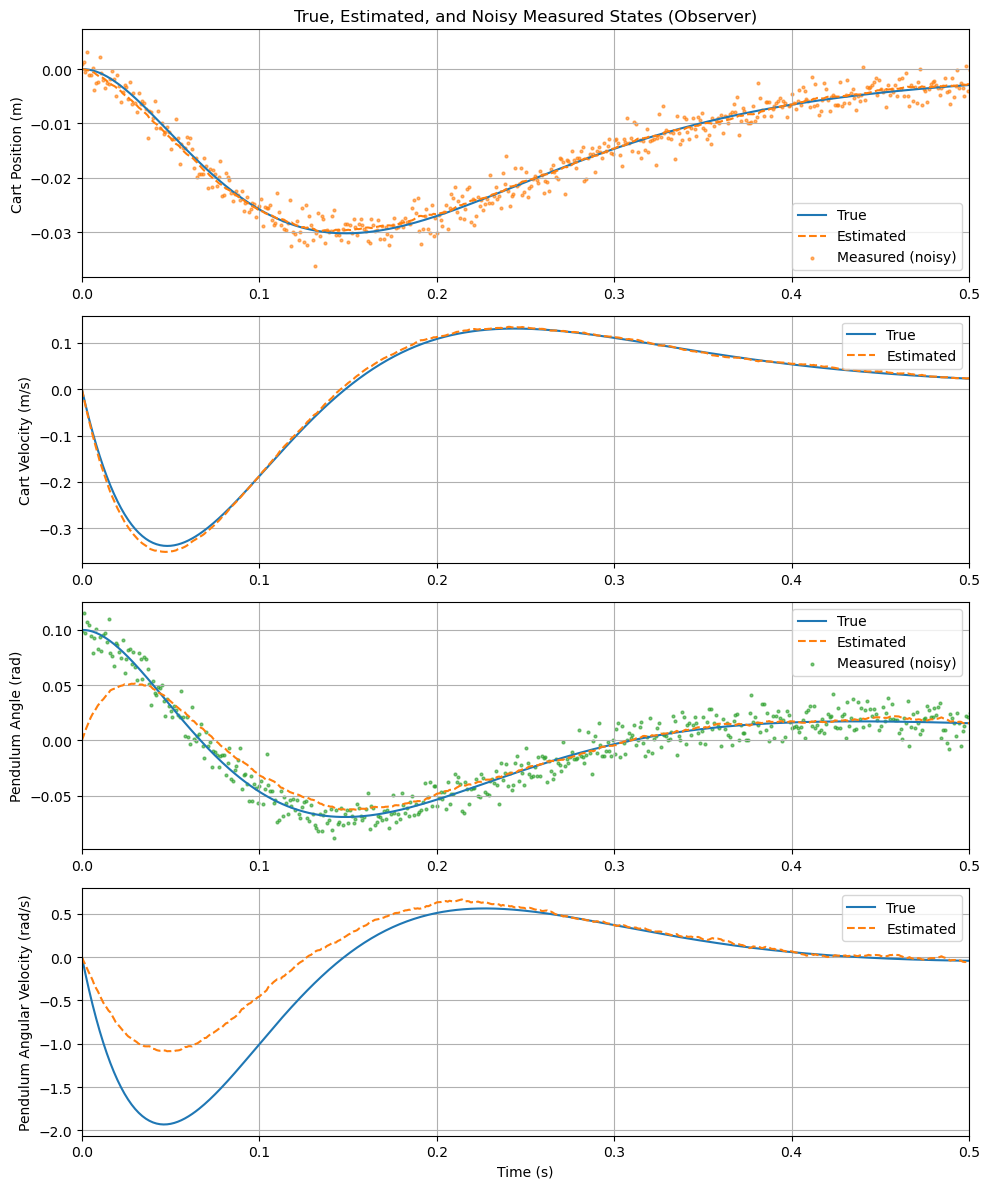

In [57]:
import scipy.linalg

# Observer design: measure x (state 0) and theta (state 2)
C_obs = np.array([[1, 0, 0, 0],
                  [0, 0, 1, 0]])

# Place observer poles
observer_poles = np.array([-20,-21,-22,-23])  # Example observer poles, can be adjusted

# If any observer pole is zero, shift it to a negative value for stability
observer_poles = np.where(observer_poles == 0, -5, observer_poles)

# Place the observer poles
L = scipy.signal.place_poles(A.T, C_obs.T, observer_poles).gain_matrix.T

# Simulate observer with measurement noise
np.random.seed(42)  # For reproducibility
noise_std = [0.002, 0.01]  # Standard deviation for x and theta measurements
X_hat = np.zeros((4, len(T)))
X_hat[:, 0] = [0, 0, 0, 0]  # Initial observer state (can be zeros)
Y = np.zeros((2, len(T)))    # Noisy measured outputs

for i in range(1, len(T)):
    # Output measurement (x and theta) with noise
    true_meas = C_obs @ X[:, i-1]
    noise = np.array([np.random.normal(0, noise_std[0]), np.random.normal(0, noise_std[1])])
    Y[:, i-1] = true_meas + noise
    # Observer update
    x_hat_dot = (A @ X_hat[:, i-1] + B.flatten() * U[i-1] +
                 L @ (Y[:, i-1] - C_obs @ X_hat[:, i-1]))
    X_hat[:, i] = X_hat[:, i-1] + x_hat_dot * dt

# Plot true vs estimated states and noisy measurements for measured states
plt.figure(figsize=(10, 12))
labels = ['Cart Position (m)', 'Cart Velocity (m/s)', 'Pendulum Angle (rad)', 'Pendulum Angular Velocity (rad/s)']
for idx in range(4):
    plt.subplot(4, 1, idx + 1)
    plt.plot(T, X[idx, :], label='True')
    plt.plot(T, X_hat[idx, :], '--', label='Estimated')
    if idx == 0:
        plt.scatter(T, Y[0, :], s=4, marker='o', color='tab:orange', label='Measured (noisy)', alpha=0.6)
    if idx == 2:
        plt.scatter(T, Y[1, :], s=4, marker='o', color='tab:green', label='Measured (noisy)', alpha=0.6)
    plt.ylabel(labels[idx])
    plt.xlim(0, 0.5)
    if idx == 0:
        plt.title('True, Estimated, and Noisy Measured States (Observer)')
    if idx == 3:
        plt.xlabel('Time (s)')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

## Observer Pole Placement

The graphs above compare the true states, estimated states, and noisy measurements for the observed variables. By analyzing these plots, we adjusted the observer pole locations to achieve a balance between estimation speed and noise sensitivity. Placing the observer poles further left (more negative real parts) resulted in faster convergence of the estimated states to the true states, but also amplified measurement noise in the estimates. Conversely, slower observer poles reduced noise amplification but delayed state estimation. Through iterative tuning and visual inspection of the estimation error and noise response in the plots, we selected observer poles that provided rapid and accurate state estimation without excessive noise amplification. We were unable to get the angular velocity of the pendulum to hit the minimum that the true state reaches. It was not clear why this is.